In [117]:
import json
import re
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
# from sklearn.svm import LinearSVC
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import fasttext

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [119]:
device

device(type='cuda')

In [120]:
def feature_transform(train_file, chunk_tags, chunk_tags_len):
    
#     column_idx = []
#     row_idx = []
    chunk_tags_len = len(chunk_tags) 
    y = []
    data = []
    feature_length = chunk_tags_len # Per head
    ctr = 0
    
    f = open(train_file, encoding='utf-8')

    for line in f:
#             ctr += 1
            row=[]
            if(line.rstrip()):
                line = re.sub("\s+"," ",line)
                line1 = line.split(";")
                # print(line1.encode('utf-8'))
                # for line2 in line1:
                #     line2=line2.encode('utf-8')
                #     print(line2.decode('utf-8'))
                a3 = line1[2].split(" ")
                a2 = line1[1].split(" ")
                a1 = line1[0].split(" ")
                y.append(a3[1])
                
                

#                 row_idx += [ctr-1]*2
#                 data += [1] * 2

                if(a1[0] == "ROOT"):
                    row.append(chunk_tags.index('ROOT'))

                elif(a1[0] == "H"):
                    row.append(chunk_tags.index(a1[4]))

                row.append(chunk_tags.index(a2[5]))
                data.append(row)

    f.close()

    return data, y


In [ ]:
train_file = './data/parsed_output_train.txt'
test_file = "./data/parsed_output_test.txt"

In [121]:
listfile = "./data/data_list.json"
f = open(listfile, encoding='utf-8')
data = json.load(f)
f.close()

chunk_tags = data["tags"]
chunk_tags_len = len(chunk_tags)



In [122]:
def one_hot_encode(X_train, num_unique_values):
    x_onehot = []
    # Iterate over each sublist in X
    for sublist in X_train:
        sublist_onehot = []  # Initialize an empty list for one-hot encodings of the sublist
        # Iterate over each value in the sublist
        for value in sublist:
            # Create one-hot encoding for the value
           
            onehot_value = np.eye(num_unique_values)[value]  # Create one-hot encoding for the value
            sublist_onehot.append(onehot_value)  # Append the one-hot encoding to the sublist_onehot list
        x_onehot.append(sublist_onehot)
    return x_onehot

In [123]:

# def find_embedding(X_train,ft):
#     x_embided = []
    
#     for sublist in X_train:
#         sublist_onehot = []  # Initialize an empty list for one-hot encodings of the sublist
#         # Iterate over each value in the sublist
#         for value in sublist:
#             # Create one-hot encoding for the value
#             word_embed=ft.get_word_vector(value)[:100]  
#             sublist_onehot.append(word_embed)  # Append the one-hot encoding to the sublist_onehot list
#         x_embided.append(sublist_onehot)
#     return x_embided
    
    
# Load the FastText model


In [124]:




    
    
    
class FFNN(nn.Module):
    def __init__(self, embedding_dim,hidden_dim, output_dim):
        super(FFNN, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.input_dim = embedding_dim * (2)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model


In [125]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Plot the training loss
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [126]:
def evaluate_model(model, test_loader, device):
    with torch.no_grad():
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Append true and predicted labels
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Total number of labels
            total += batch_y.size(0)

            # Total correct predictions
            correct += (predicted == batch_y).sum().item()

        test_accuracy = 100 * correct / total
        return y_true, y_pred, test_accuracy

In [127]:
def plot_classification_matrix(y_true, y_pred, labels):
    try:
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.set(font_scale=1.2)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Classification Matrix')
        plt.show()
    except ValueError as e:
        print(e)

def print_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))

In [128]:
X_train, y_train = feature_transform(train_file, chunk_tags, chunk_tags_len)
X_test, y_test = feature_transform(test_file, chunk_tags, chunk_tags_len)


In [129]:
print(y_train[0:10])

['R', 'R', 'R', 'L', 'L', 'U', 'U', 'U', 'U', 'U']


In [130]:
print(X_train[0:10])

[[0, 1], [1, 2], [3, 2], [14, 2], [2, 4], [1, 3], [0, 2], [3, 4], [1, 4], [0, 4]]


In [131]:
# Define your data
X_train=np.array(X_train)
num_unique_values=15
X_train_onehot = one_hot_encode(X_train, num_unique_values)  # Append the sublist_onehot list to the x_onehot list

X_test_onehot = one_hot_encode(X_test, num_unique_values)
# Convert x_onehot to a numpy array
X_train = np.array(X_train_onehot)
X_test = np.array(X_test_onehot)
print(X_train[0])
print(X_train[1])


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [132]:
label_dict = {'R': 0, 'L': 1, 'U': 2}
y_numerical = np.array([label_dict[label] for label in y_train])

# Convert data to PyTorch tensors
x_tensor_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor(y_numerical, dtype=torch.long).to(device)


In [133]:
y_numerical_test = np.array([label_dict[label] for label in y_test])

# Convert data to PyTorch tensors
x_tensor_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_tensor_test = torch.tensor(y_numerical_test, dtype=torch.long).to(device)

In [134]:
print(x_tensor_test.shape)
print(y_tensor_test.shape)

torch.Size([36141, 2, 15])
torch.Size([36141])


In [135]:
train_dataset = TensorDataset(x_tensor_train, y_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [136]:
test_dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=1)

In [137]:
print(len(train_loader))

8465


In [138]:


input_size = len(X_train[0][0])  # Number of features after one-hot encoding
print(input_size)
hidden_size = 64  # Number of units in the hidden layer
num_classes = 3  # Number of output classes
num_epochs=10
model = FFNN(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop


15


 10%|█         | 1/10 [00:13<02:04, 13.79s/it]

Epoch 1/10, Loss: 0.4873162150347789


 20%|██        | 2/10 [00:27<01:49, 13.70s/it]

Epoch 2/10, Loss: 0.47437857589247096


 30%|███       | 3/10 [00:40<01:35, 13.63s/it]

Epoch 3/10, Loss: 0.47385472735391165


 40%|████      | 4/10 [00:54<01:22, 13.68s/it]

Epoch 4/10, Loss: 0.4734320408781815


 50%|█████     | 5/10 [01:08<01:08, 13.62s/it]

Epoch 5/10, Loss: 0.4732425650318769


 60%|██████    | 6/10 [01:21<00:54, 13.65s/it]

Epoch 6/10, Loss: 0.47293218882106425


 70%|███████   | 7/10 [01:35<00:40, 13.64s/it]

Epoch 7/10, Loss: 0.47274163797524155


 80%|████████  | 8/10 [01:49<00:27, 13.67s/it]

Epoch 8/10, Loss: 0.4727458690987912


 90%|█████████ | 9/10 [02:02<00:13, 13.66s/it]

Epoch 9/10, Loss: 0.47262236316987066


100%|██████████| 10/10 [02:16<00:00, 13.66s/it]

Epoch 10/10, Loss: 0.47254176892899086


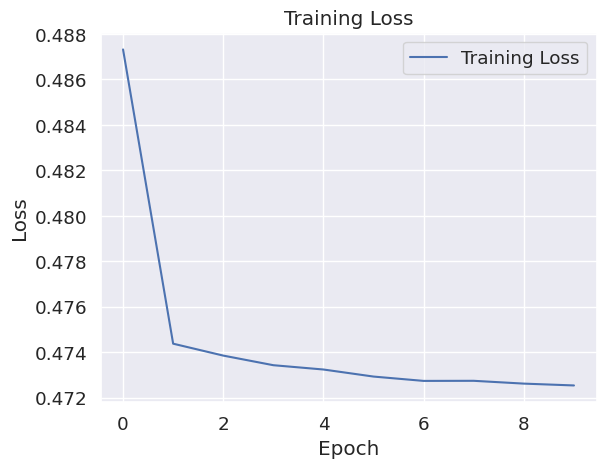

In [139]:
train_model(model, train_loader, criterion, optimizer, num_epochs)

In [140]:
y_true, y_pred, test_accuracy = evaluate_model(model, test_loader, device)

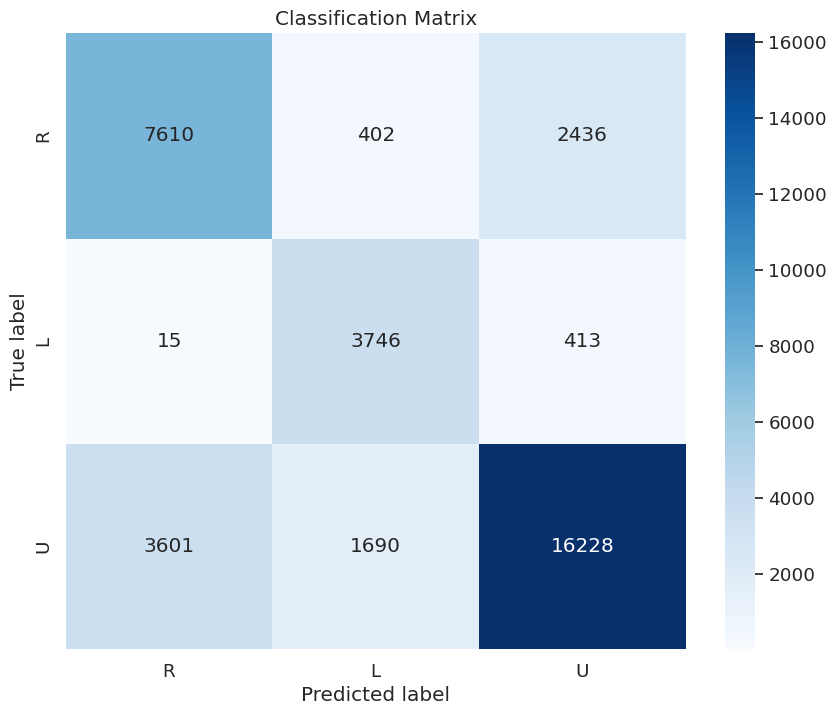

In [141]:
 plot_classification_matrix(y_true, y_pred, labels=['R', 'L', 'U'])

In [142]:
print_classification_report(y_true, y_pred, labels=['R', 'L', 'U'])

              precision    recall  f1-score   support

           R       0.68      0.73      0.70     10448
           L       0.64      0.90      0.75      4174
           U       0.85      0.75      0.80     21519

    accuracy                           0.76     36141
   macro avg       0.72      0.79      0.75     36141
weighted avg       0.78      0.76      0.77     36141

